In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.metrics import confusion_matrix
print("ddd")

ddd


General Functions that are used throughout the code

In [33]:
def create_combined_mask(img_cyto, img_nuc):
    """Create a combined mask with cytoplasm (gray) and nucleus (white)."""
    combined_mask = np.zeros_like(img_cyto, dtype=np.uint8)
    combined_mask[img_cyto > 0] = 128  # Gray for cytoplasm
    combined_mask[img_nuc > 0] = 255   # White for nucleus
    return combined_mask

def dice_coefficient(mask1, mask2):
    """Compute the Dice coefficient between two binary masks."""
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    sum_masks = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    return (2. * intersection) / sum_masks if sum_masks != 0 else 1.0

def connectivit_8(image, limit, padd_size):
    """Perform 8-connectivity labeling."""
    height, width = image.shape
    connect_8 = np.zeros((height, width), dtype=np.int32)
    eq_list = {}
    label = 1

    for i in range(padd_size, height - padd_size):
        for j in range(padd_size, width - padd_size):
            if 0 <= image[i, j] <= limit:
                neighbors = []
                if connect_8[i, j - padd_size] > 0:
                    neighbors.append(connect_8[i, j - padd_size])
                if connect_8[i - padd_size, j] > 0:
                    neighbors.append(connect_8[i - padd_size, j])
                if connect_8[i - padd_size, j - padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j - padd_size])
                if connect_8[i - padd_size, j + padd_size] > 0:
                    neighbors.append(connect_8[i - padd_size, j + padd_size])
                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[neighbor] = min_label

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = eq_list[connect_8[i, j]]
    return connect_8

Analysis on 1 Image

In [51]:
# Paths
image_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images\\003.bmp"
mask_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\masks\\003.png"

def histogram(img):
    array = [0] * 256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel_val = int(img[i, j])
            array[pixel_val] += 1
    array = np.array(array)
    return array

def compute_confusion_matrix(pred_mask, gt_mask):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()


    labels = [0, 128, 255]

    cm = confusion_matrix(gt_flat, pred_flat, labels=labels)
    return cm
def histogram(img):
    array = [0] * 256
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel_val = int(img[i, j])
            array[pixel_val] += 1
    array = np.array(array)
    return array



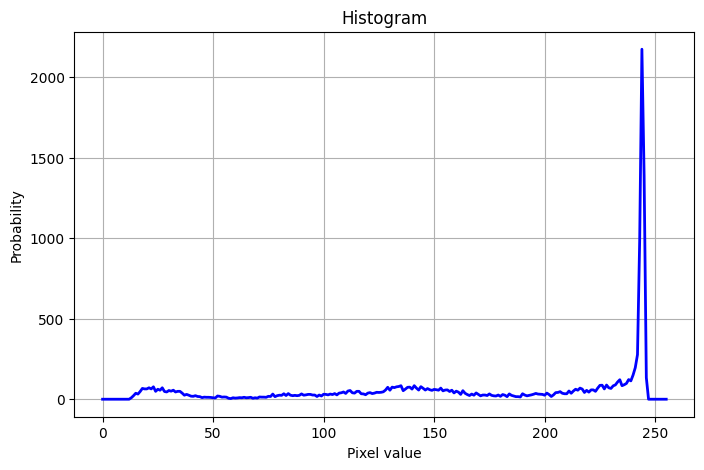

In [52]:
img= cv2.imread(image_path, 0)
hist = histogram(img)
plt.figure(figsize=(8, 5))
plt.plot(range(256), hist, color='blue', linewidth=2)
plt.title("Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Probability")
plt.grid()
plt.show()

After seeing the histogram it is clearly visible the domainance of 255 as the most frequent Value

In this analysis, pixels with intensity 255 were excluded because they represent the background and do not contribute to meaningful segmentation.

Threshold Calculation:

The mean and standard deviation were computed only for valid pixels (excluding 255).
Nucleus Threshold: mean - (k1 * std_dev)
Cytoplasm Threshold: mean
Segmentation Process:

8-Connectivity Labeling (connectivit_8) was applied to separate cytoplasm and nucleus.
A combined mask was created where cytoplasm = 128 (gray) and nucleus = 255 (white).
Removing 255 (background pixels) ensures that threshold calculations are not skewed by outliers, leading to more accurate segmentation.

Dice Coefficient: 0.9678


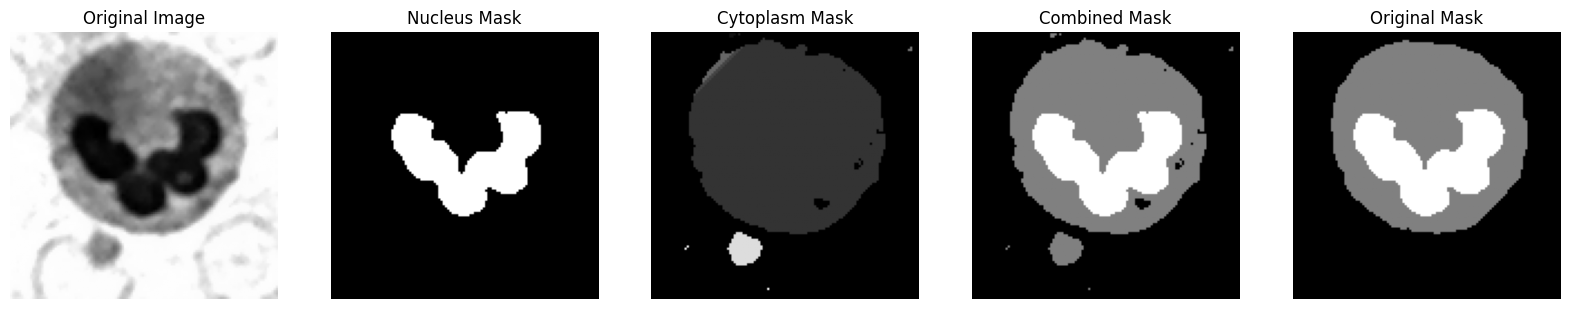

In [55]:
# Load images
original_image = cv2.imread(image_path, 0)
ground_truth_mask = cv2.imread(mask_path, 0)

# Ensure images are loaded
if original_image is None or ground_truth_mask is None:
    raise FileNotFoundError("One or both files not found.")

# Compute thresholds
k1 = k2 = 1.5

valid_pixels = original_image[original_image < 255]
mean_intensity = np.mean(valid_pixels)
std_dev_intensity = np.std(valid_pixels)
nucleus_thresh = mean_intensity - k1 * std_dev_intensity
cytoplasm_thresh = mean_intensity 

# Generate segmented images
img_cyto = connectivit_8(original_image, cytoplasm_thresh, 1)
img_nuc = connectivit_8(original_image, nucleus_thresh, 1)

# Generate combined mask
combined_mask = create_combined_mask(img_cyto, img_nuc)

# Compute Dice coefficient
dice_score = dice_coefficient(combined_mask, ground_truth_mask)
print(f"Dice Coefficient: {dice_score:.4f}")

# Plot images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(img_nuc, cmap='gray')
axes[1].set_title("Nucleus Mask")
axes[1].axis("off")

axes[2].imshow(img_cyto, cmap='gray')
axes[2].set_title("Cytoplasm Mask")
axes[2].axis("off")

axes[3].imshow(combined_mask, cmap='gray')
axes[3].set_title("Combined Mask")
axes[3].axis("off")

axes[4].imshow(ground_truth_mask, cmap='gray')
axes[4].set_title("Original Mask")
axes[4].axis("off")

plt.show()


Confusion Matrix:
 [[8172  232    0]
 [ 156 4129    3]
 [   0   48 1660]]


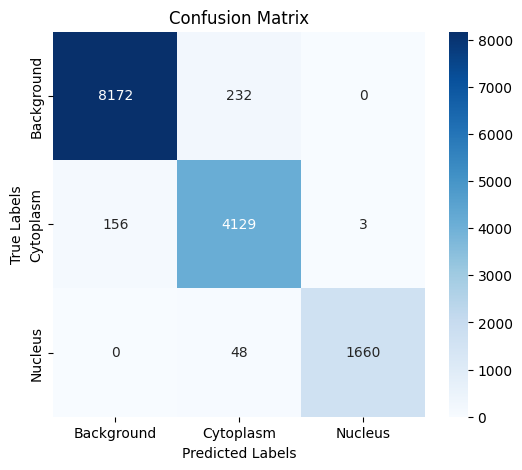

In [56]:
# Get confusion matrix
cm = compute_confusion_matrix(combined_mask, ground_truth_mask)
print("Confusion Matrix:\n", cm)
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Cytoplasm", "Nucleus"],
            yticklabels=["Background", "Cytoplasm", "Nucleus"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



Processig on the Train Data

Compute Accuracy (compute_accuracy)

Compares predicted mask with ground truth mask.
Returns percentage of correctly classified pixels.
Process Dataset (process_dataset)

Loads images (.bmp) and masks (.png).
Computes dynamic thresholds using mean & standard deviation.
Segments WBCs using 8-connectivity labeling.
Creates a combined mask (Cytoplasm = 128, Nucleus = 255, Background = 0).
Evaluates segmentation using:
Dice Coefficient (Measures overlap).
Pixel Accuracy (Measures correctly classified pixels).
Saves results (thresholds, Dice, Accuracy) in a CSV file.
Prints results for each image.

In [57]:
def compute_accuracy(pred_mask, gt_mask):
    """Compute accuracy between predicted and ground truth masks without binarization."""
    TP_TN = np.sum(pred_mask == gt_mask)  # Pixels where both match
    total_pixels = pred_mask.size  # Total number of pixels
    return TP_TN / total_pixels if total_pixels != 0 else 1.0


def process_dataset(train_images_path, train_masks_path, output_csv):
    """Process all images in the dataset and store results in a DataFrame."""
    
    results = []

    for filename in os.listdir(train_images_path):
        if filename.endswith(".bmp"):
            img_path = os.path.join(train_images_path, filename)
            mask_filename = filename.replace(".bmp", ".png")
            mask_path = os.path.join(train_masks_path, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Mask not found for {filename}, skipping...")
                continue

            img = cv2.imread(img_path, 0)
            if img is None:
                print(f"Failed to read {filename}, skipping...")
                continue

            # Compute thresholds dynamically
            k1 = k2 = 1.5
            valid_pixels = img[img < 255]
            mean_intensity = np.mean(valid_pixels)
            std_dev_intensity = np.std(valid_pixels)
            nucleus_thresh = mean_intensity - k1 * std_dev_intensity
            cytoplasm_thresh = mean_intensity

            # Generate segmented images
            img_cyto = connectivit_8(img, cytoplasm_thresh, 1)
            img_nuc = connectivit_8(img, nucleus_thresh, 1)

            # Create combined mask (without binarization)
            combined_mask = create_combined_mask(img_cyto, img_nuc)

            # Read and process ground truth mask (without binarization)
            ground_truth_mask = cv2.imread(mask_path, 0)
            if ground_truth_mask is None:
                print(f"Failed to read mask {mask_filename}, skipping...")
                continue

            # Compute Dice coefficient
            dice_score = dice_coefficient(combined_mask, ground_truth_mask)

            # Compute Accuracy (without binarization)
            accuracy = compute_accuracy(combined_mask, ground_truth_mask)

            # Store results in a list
            results.append({
                "Image": filename,
                "Cytoplasm_Threshold": round(cytoplasm_thresh, 2),
                "Nucleus_Threshold": round(nucleus_thresh, 2),
                "Dice_Score": round(dice_score, 4),
                "Accuracy": round(accuracy, 4)
            })

            print(f"{filename}: Dice Score = {dice_score:.4f}, Accuracy = {accuracy:.4f}")

    # Convert to DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_csv, index=False)
    return df_results

# Example usage
train_images_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\images"
train_masks_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train\\masks"
output_csv = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\train_results.csv"

df_train = process_dataset(train_images_path, train_masks_path, output_csv)


003.bmp: Dice Score = 0.9678, Accuracy = 0.9695
004.bmp: Dice Score = 0.9460, Accuracy = 0.9587
005.bmp: Dice Score = 0.8045, Accuracy = 0.8118
006.bmp: Dice Score = 0.9811, Accuracy = 0.9758
007.bmp: Dice Score = 0.9079, Accuracy = 0.9469
008.bmp: Dice Score = 0.9506, Accuracy = 0.9469
009.bmp: Dice Score = 0.9836, Accuracy = 0.9695
010.bmp: Dice Score = 0.9721, Accuracy = 0.9428
011.bmp: Dice Score = 0.9641, Accuracy = 0.9664
012.bmp: Dice Score = 0.9753, Accuracy = 0.9590
013.bmp: Dice Score = 0.8921, Accuracy = 0.8284
014.bmp: Dice Score = 0.9329, Accuracy = 0.9455
015.bmp: Dice Score = 0.9764, Accuracy = 0.9619
016.bmp: Dice Score = 0.9506, Accuracy = 0.9629
017.bmp: Dice Score = 0.9752, Accuracy = 0.9746
018.bmp: Dice Score = 0.9506, Accuracy = 0.9540
019.bmp: Dice Score = 0.9552, Accuracy = 0.9637
020.bmp: Dice Score = 0.9694, Accuracy = 0.9615
021.bmp: Dice Score = 0.9805, Accuracy = 0.9260
022.bmp: Dice Score = 0.9730, Accuracy = 0.9712
023.bmp: Dice Score = 0.9791, Accuracy =

In [38]:
df_train.head()

,Image,Cytoplasm_Threshold,Nucleus_Threshold,Dice_Score,Accuracy
0,003.bmp,179.22,69.00,0.9678,0.9695
1,004.bmp,197.30,94.67,0.9460,0.9587
2,005.bmp,177.25,71.77,0.8045,0.8118
3,006.bmp,181.92,84.33,0.9811,0.9758
4,007.bmp,193.89,97.18,0.9079,0.9469


From the train imgaes i calculated the Average of the Cytoplasm and Nucles Threshold Vales

In [42]:
def round_num(value):
    """Round off such that if decimal < 0.5 -> round down, else -> round up."""
    return int(value) if value % 1 < 0.5 else int(value) + 1

# Apply custom rounding


avg_Cytoplasm_Threshold = round_num(df_train['Cytoplasm_Threshold'].mean())
avg_Nucleus_Threshold = round_num(df_train["Nucleus_Threshold"].mean())
avg_Cytoplasm_Threshold, avg_Nucleus_Threshold

(190, 97)

Procssing of test Data

Computed average threshold values (avg_Cytoplasm_Threshold, avg_Nucleus_Threshold) from train images.

Used these precomputed thresholds for segmenting test images instead of calculating dynamically.

Applied 8-connectivity labeling to segment cytoplasm and nucleus in test images.

Evaluated segmentation using Dice Score and Pixel Accuracy.

In [59]:
def process_dataset(train_images_path, train_masks_path, output_csv, nucleus_thresh, cytoplasm_thresh):
    """Process all images in the dataset and store results in a DataFrame."""
    
    results = []

    for filename in os.listdir(train_images_path):
        if filename.endswith(".bmp"):
            img_path = os.path.join(train_images_path, filename)
            mask_filename = filename.replace(".bmp", ".png")
            mask_path = os.path.join(train_masks_path, mask_filename)

            if not os.path.exists(mask_path):
                print(f"Mask not found for {filename}, skipping...")
                continue

            img = cv2.imread(img_path, 0)
            if img is None:
                print(f"Failed to read {filename}, skipping...")
                continue

            # Generate segmented images
            img_cyto = connectivit_8(img, cytoplasm_thresh, 1)
            img_nuc = connectivit_8(img, nucleus_thresh, 1)

            # Create combined mask (without binarization)
            combined_mask = create_combined_mask(img_cyto, img_nuc)

            # Read and process ground truth mask (without binarization)
            ground_truth_mask = cv2.imread(mask_path, 0)
            if ground_truth_mask is None:
                print(f"Failed to read mask {mask_filename}, skipping...")
                continue

            # Compute Dice coefficient
            dice_score = dice_coefficient(combined_mask, ground_truth_mask)

            # Compute Accuracy (without binarization)
            accuracy = compute_accuracy(combined_mask, ground_truth_mask)

            # Store results in a list
            results.append({
                "Image": filename,
                "Cytoplasm_Threshold": round(cytoplasm_thresh, 2),
                "Nucleus_Threshold": round(nucleus_thresh, 2),
                "Dice_Score": round(dice_score, 4),
                "Accuracy": round(accuracy, 4)
            })

            print(f"{filename}: Dice Score = {dice_score:.4f}, Accuracy = {accuracy:.4f}")

    # Convert to DataFrame and save to CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_csv, index=False)
    return df_results

# Example usage
train_images_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\images"
train_masks_path = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test\\masks"
output_csv = "E:\\2. DIP\\2. LAB\\pythonProject\\Assignment\\dataset_DIP_assignment\\test_.csv"

df_test = process_dataset(train_images_path, train_masks_path, output_csv, avg_Nucleus_Threshold, avg_Cytoplasm_Threshold)

241.bmp: Dice Score = 0.9781, Accuracy = 0.9794
242.bmp: Dice Score = 0.8936, Accuracy = 0.9398
243.bmp: Dice Score = 0.9126, Accuracy = 0.9479
244.bmp: Dice Score = 0.8251, Accuracy = 0.9050
245.bmp: Dice Score = 0.8373, Accuracy = 0.9108
246.bmp: Dice Score = 0.9250, Accuracy = 0.9576
247.bmp: Dice Score = 0.9140, Accuracy = 0.9490
248.bmp: Dice Score = 0.8239, Accuracy = 0.9001
249.bmp: Dice Score = 0.8558, Accuracy = 0.9081
250.bmp: Dice Score = 0.8828, Accuracy = 0.9323
251.bmp: Dice Score = 0.9712, Accuracy = 0.9785
252.bmp: Dice Score = 0.9371, Accuracy = 0.9656
253.bmp: Dice Score = 0.9623, Accuracy = 0.9740
254.bmp: Dice Score = 0.9326, Accuracy = 0.9647
255.bmp: Dice Score = 0.9538, Accuracy = 0.9649
256.bmp: Dice Score = 0.9479, Accuracy = 0.9679
257.bmp: Dice Score = 0.9757, Accuracy = 0.9603
258.bmp: Dice Score = 0.9183, Accuracy = 0.9430
259.bmp: Dice Score = 0.9232, Accuracy = 0.9591
260.bmp: Dice Score = 0.9808, Accuracy = 0.7893
261.bmp: Dice Score = 0.9382, Accuracy =

In [30]:
df_test.head()

,Image,Cytoplasm_Threshold,Nucleus_Threshold,Dice_Score,Accuracy
0,241.bmp,190,97,0.9781,0.9794
1,242.bmp,190,97,0.8936,0.9398
2,243.bmp,190,97,0.9126,0.9479
3,244.bmp,190,97,0.8251,0.9050
4,245.bmp,190,97,0.8373,0.9108


In [45]:
df_test['Dice_Score'].mean(), df_test["Accuracy"].mean()

(np.float64(0.9301366666666666), np.float64(0.9439616666666667))

In [62]:
df_test.to_csv("test_results.csv", index=False)